# Preparing Enviroment

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
! pip install pyspark -q

In [ ]:
from pyspark.sql import SparkSession
from pyspark import SparkContext

sc = SparkContext.getOrCreate()

spark = SparkSession\
    .builder\
    .appName('IST418 Project')\
    .getOrCreate()

# Loading in Data

In [ ]:
df = spark\
  .read\
  .option("header", "true")\
  .option("inferSchema", "true")\
  .csv("/content/drive/MyDrive/IST418/Airline Satisfaction/train.csv")\
  .drop('_c0')\
  .drop('id')

In [ ]:
df\
.show(10)

+------+-----------------+---+---------------+--------+---------------+---------------------+---------------------------------+----------------------+-------------+--------------+---------------+------------+----------------------+----------------+----------------+----------------+---------------+----------------+-----------+--------------------------+------------------------+--------------------+
|Gender|    Customer Type|Age| Type of Travel|   Class|Flight Distance|Inflight wifi service|Departure/Arrival time convenient|Ease of Online booking|Gate location|Food and drink|Online boarding|Seat comfort|Inflight entertainment|On-board service|Leg room service|Baggage handling|Checkin service|Inflight service|Cleanliness|Departure Delay in Minutes|Arrival Delay in Minutes|        satisfaction|
+------+-----------------+---+---------------+--------+---------------+---------------------+---------------------------------+----------------------+-------------+--------------+---------------+---

# One Hot Encoding

In [ ]:
from pyspark.ml import Pipeline, feature
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml.feature import StandardScaler
from pyspark.ml.feature import PCA

string_indexer = StringIndexer(inputCols=['Gender', 'Customer Type', 'Type of Travel', 'satisfaction', 'Class'],
                                outputCols=['gender_indexed', 'customer_indexed', 'type_indexed', 'satisfaction_indexed', 'class_indexed'],
                                handleInvalid='skip')

indexerModel = string_indexer.fit(df)
indexed_df = indexerModel.transform(df)

indexed_df = indexed_df.drop("Gender", "Customer Type", "Type of Travel", "satisfaction", "Class")

ohe = OneHotEncoder(inputCols =
                    [
                        'class_indexed', 'Inflight wifi service', 'Departure/Arrival time convenient',
                        'Ease of Online booking', 'Gate location', 'Food and drink', 'Online boarding',
                        'Seat comfort', 'Inflight entertainment', 'On-board service', 'Leg room service',
                        'Baggage handling', 'Checkin service', 'Inflight service', 'Cleanliness'
                    ],
                    outputCols =
                    [
                        'class_ohe', 'wifi_ohe', 'dep_arrival_ohe', 'onlinebooking_ohe', 'gate_ohe',
                        'food_ohe', 'boarding_ohe', 'seat_ohe', 'entertainment_ohe', 'onboard_ohe',
                        'legroom_ohe', 'baggage_ohe', 'checkin_ohe', 'inflight_ohe', 'cleanliness_ohe'
                    ])

encoded_df = ohe.fit(indexed_df).transform(indexed_df)
encoded_df = encoded_df.drop("class_indexed", 'Inflight wifi service', 'Departure/Arrival time convenient',
                        'Ease of Online booking', 'Gate location', 'Food and drink', 'Online boarding',
                        'Seat comfort', 'Inflight entertainment', 'On-board service', 'Leg room service',
                        'Baggage handling', 'Checkin service', 'Inflight service', 'Cleanliness')
encoded_df.show()

+---+---------------+--------------------------+------------------------+--------------+----------------+------------+--------------------+-------------+-------------+---------------+-----------------+-------------+-------------+-------------+-------------+-----------------+-------------+-------------+-------------+-------------+-------------+---------------+
|Age|Flight Distance|Departure Delay in Minutes|Arrival Delay in Minutes|gender_indexed|customer_indexed|type_indexed|satisfaction_indexed|    class_ohe|     wifi_ohe|dep_arrival_ohe|onlinebooking_ohe|     gate_ohe|     food_ohe| boarding_ohe|     seat_ohe|entertainment_ohe|  onboard_ohe|  legroom_ohe|  baggage_ohe|  checkin_ohe| inflight_ohe|cleanliness_ohe|
+---+---------------+--------------------------+------------------------+--------------+----------------+------------+--------------------+-------------+-------------+---------------+-----------------+-------------+-------------+-------------+-------------+-----------------+-

# PCA Creation

In [ ]:
airline_pipe = Pipeline(stages =
                        [
                        feature.VectorAssembler(inputCols =
                                      [
                                        'gender_indexed', 'customer_indexed', 'type_indexed', 'satisfaction_indexed',
                                        'class_ohe', 'wifi_ohe', 'dep_arrival_ohe', 'onlinebooking_ohe', 'gate_ohe',
                                        'food_ohe', 'boarding_ohe', 'seat_ohe', 'entertainment_ohe', 'onboard_ohe',
                                        'legroom_ohe', 'baggage_ohe', 'checkin_ohe', 'inflight_ohe', 'cleanliness_ohe'
                                      ],
                                                outputCol = 'features'),

                        feature.StandardScaler(withMean = True,
                                               withStd = True,
                                               inputCol = 'features',
                                               outputCol = 'zfeatures'),
                        feature.PCA(k=19,
                                    inputCol = 'zfeatures',
                                    outputCol = 'scores')

                        ]).fit(encoded_df)

df_transformed = airline_pipe.transform(encoded_df)

In [ ]:
df_transformed\
.show(10)

+---+---------------+--------------------------+------------------------+--------------+----------------+------------+--------------------+-------------+-------------+---------------+-----------------+-------------+-------------+-------------+-------------+-----------------+-------------+-------------+-------------+-------------+-------------+---------------+--------------------+--------------------+--------------------+
|Age|Flight Distance|Departure Delay in Minutes|Arrival Delay in Minutes|gender_indexed|customer_indexed|type_indexed|satisfaction_indexed|    class_ohe|     wifi_ohe|dep_arrival_ohe|onlinebooking_ohe|     gate_ohe|     food_ohe| boarding_ohe|     seat_ohe|entertainment_ohe|  onboard_ohe|  legroom_ohe|  baggage_ohe|  checkin_ohe| inflight_ohe|cleanliness_ohe|            features|           zfeatures|              scores|
+---+---------------+--------------------------+------------------------+--------------+----------------+------------+--------------------+-----------

In [ ]:
loadings = airline_pipe.stages[-1].pc.toArray()
print('loadings.shape', loadings.shape)

loadings.shape (76, 19)


In [ ]:
print(loadings[:,0])

[-5.21612527e-03  7.00904346e-02  1.64200164e-01 -2.96662500e-01
 -2.37075054e-01  2.18996481e-01 -1.37807011e-02  1.31380954e-02
  1.11790963e-01  8.59602524e-02 -1.56948282e-01  1.60128497e-02
 -2.85851664e-02  1.82764591e-02  3.08835642e-02 -2.49975645e-02
  6.41079300e-03 -6.42096671e-03  7.51407024e-02  7.02954893e-02
 -1.00361537e-01 -9.91501255e-04 -3.90031171e-02  1.09000684e-02
  7.21218424e-02 -1.43442801e-02  4.16682439e-03  1.44949412e-01
  8.51871228e-02  2.88648541e-02 -1.90420557e-01  1.99899209e-02
  7.91442089e-02  1.52251595e-01  1.24918605e-01 -1.91790355e-01
 -1.15451503e-03  1.35805217e-01  1.47156727e-01  1.00580599e-01
 -2.10824250e-01  8.99014288e-04  1.60235839e-01  1.70685397e-01
  9.93081830e-02 -2.96230915e-01  2.84145423e-05  1.02581168e-01
  1.05231260e-01  7.99273870e-02 -1.69939677e-01  1.06003137e-02
  8.47273318e-02  8.98385840e-02  8.01740089e-02 -1.63839720e-01
  0.00000000e+00  6.09564883e-02  9.09591011e-02  1.22976670e-01
 -1.40993263e-01 -1.15451

In [ ]:
airline_pipe.stages[-1].explainedVariance

DenseVector([0.0675, 0.0503, 0.0492, 0.0422, 0.0405, 0.0392, 0.0376, 0.036, 0.0338, 0.0324, 0.0299, 0.0283, 0.0282, 0.0211, 0.0206, 0.0195, 0.0186, 0.0183, 0.0176])

In [ ]:
sum(airline_pipe.stages[-1].explainedVariance)

np.float64(0.6308205288985791)

Text(0, 0.5, 'Proportion Variance Explained')

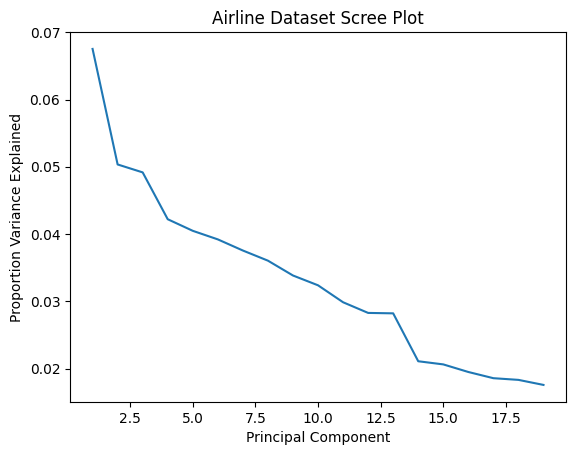

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure()
explained_var = airline_pipe.stages[-1].explainedVariance
plt.plot(np.arange(1, len(explained_var) + 1), explained_var)
plt.title('Airline Dataset Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Proportion Variance Explained')

Text(0, 0.5, 'Cumulative Sum of Variance Explained')

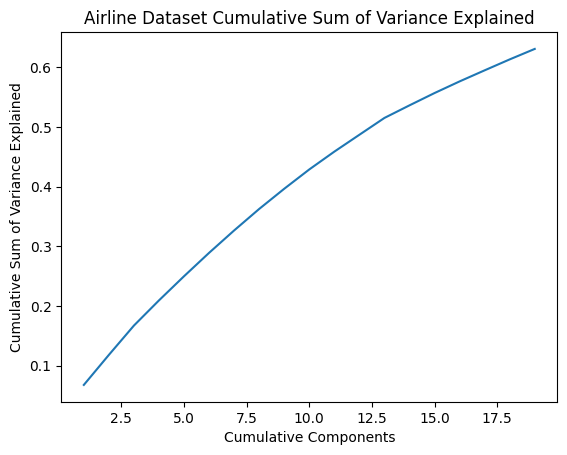

In [ ]:
cum_sum = np.cumsum(explained_var)
plt.figure()
plt.plot(np.arange(1, len(explained_var)+1), cum_sum)
plt.title('Airline Dataset Cumulative Sum of Variance Explained')
plt.xlabel('Cumulative Components')
plt.ylabel('Cumulative Sum of Variance Explained')

In [ ]:
import pandas as pd

features = ['gender_indexed', 'customer_indexed', 'type_indexed', 'satisfaction_indexed',
            'class_ohe', 'wifi_ohe', 'dep_arrival_ohe', 'onlinebooking_ohe', 'gate_ohe',
            'food_ohe', 'boarding_ohe', 'seat_ohe', 'entertainment_ohe', 'onboard_ohe',
            'legroom_ohe', 'baggage_ohe', 'checkin_ohe', 'inflight_ohe', 'cleanliness_ohe']

pd.DataFrame(
    list(zip(features, loadings[:, 0], loadings[:, 1], loadings[:, 2])),
    columns=['Feature', 'PC1', 'PC2', 'PC3']
)\
.sort_values(by='PC1',
             ascending=False)\
             .reset_index(drop=True)

,Feature,PC1,PC2,PC3
0,wifi_ohe,0.218996,-0.028315,-0.017141
1,type_indexed,0.164200,-0.026470,-0.009199
2,gate_ohe,0.111791,0.297151,-0.030282
3,food_ohe,0.085960,-0.183280,0.277317
4,cleanliness_ohe,0.075141,0.231249,-0.033138
5,customer_indexed,0.070090,-0.014275,-0.022079
6,legroom_ohe,0.030884,-0.090356,0.156576
7,onboard_ohe,0.018276,0.164552,-0.005655
8,seat_ohe,0.016013,-0.013410,-0.028310
9,onlinebooking_ohe,0.013138,-0.132668,-0.254949


# Final Modeling

## Train/Test Split

In [ ]:
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

train_df, test_df = encoded_df.randomSplit([0.8,0.2], seed=42)
train_df = train_df.na.drop()
test_df = test_df.na.drop()

## Vector Assembly and Evaluator Construction

In [ ]:
feature_cols = [
    "Age",
    "Flight Distance",
    "gender_indexed",
    "customer_indexed",
    "type_indexed",
    "class_ohe"
]


va = VectorAssembler(
    inputCols=feature_cols,
    outputCol="features"
)


bce = BinaryClassificationEvaluator(
    labelCol="satisfaction_indexed",
    rawPredictionCol="rawPrediction",
    metricName="areaUnderROC"
)

## Random Forest

In [ ]:
rf = RandomForestClassifier(
    featuresCol="features",
    labelCol="satisfaction_indexed"
)

rf_model = Pipeline(stages=[va, rf]).fit(train_df)


rf_preds = rf_model.transform(test_df)

print("Random Forest AUC:", bce.evaluate(rf_preds))

Random Forest AUC: 0.8522951621596284


## Logistic Regression

In [ ]:
lr = LogisticRegression(
    featuresCol="features",
    labelCol="satisfaction_indexed"
)

lr_model = Pipeline(stages = [va, lr]).fit(train_df)

lr_preds = lr_model.transform(test_df)

print("Logistic Regression AUC:", bce.evaluate(lr_preds))

Logistic Regression AUC: 0.8356291348739953


## Gradient Boosted Tree

In [ ]:
gbt = GBTClassifier(
    featuresCol='features',
    labelCol='satisfaction_indexed'
)

gbt_model = Pipeline(stages=[va, gbt]).fit(train_df)

gbt_preds = gbt_model.transform(test_df)

print("Gradient Boosted Tree AUC:", bce.evaluate(gbt_preds))

Gradient Boosted Tree AUC: 0.8643282313246562


## Plotting

### Random Forest ROC Curve

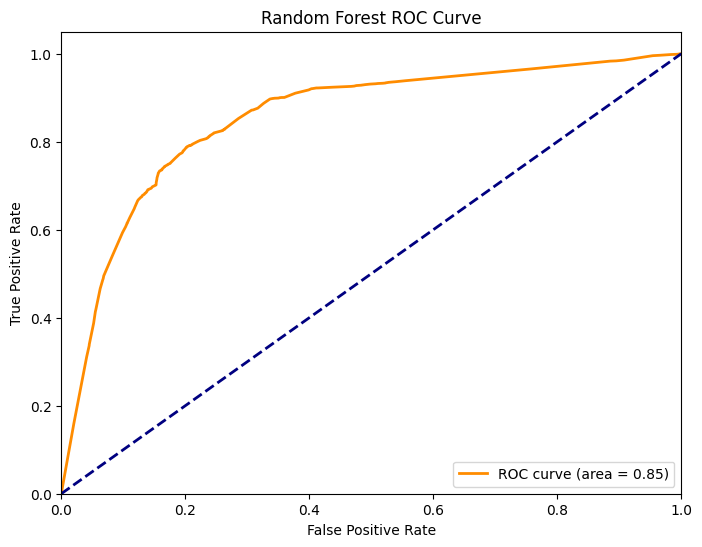

In [ ]:
rf_true = rf_preds.select('satisfaction_indexed').collect()
rf_true = [row['satisfaction_indexed'] for row in rf_true]

rf_pred = rf_preds.select('probability').rdd.map(lambda row: row[0][1]).collect()
rf_pred = [float(prob) for prob in rf_pred]

fpr, tpr, _ = roc_curve(rf_true, rf_pred)
rf_roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {rf_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest ROC Curve')
plt.legend(loc='lower right')
plt.show()

### Logistic Regression Curve

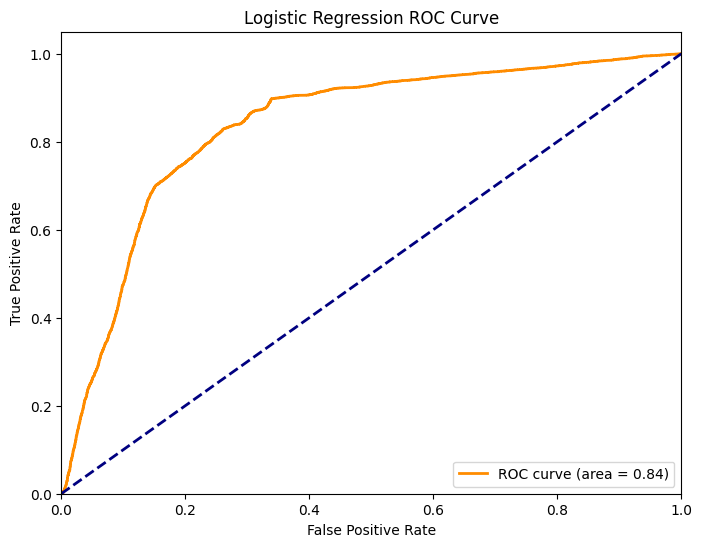

In [ ]:
y_true = lr_preds.select('satisfaction_indexed').collect()
y_true = [row['satisfaction_indexed'] for row in y_true]

y_pred = lr_preds.select('probability').rdd.map(lambda row: row[0][1]).collect()
y_pred = [float(prob) for prob in y_pred]

fpr, tpr, _ = roc_curve(y_true, y_pred)
lr_roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {lr_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression ROC Curve')
plt.legend(loc='lower right')
plt.show()

### GBT ROC Curve

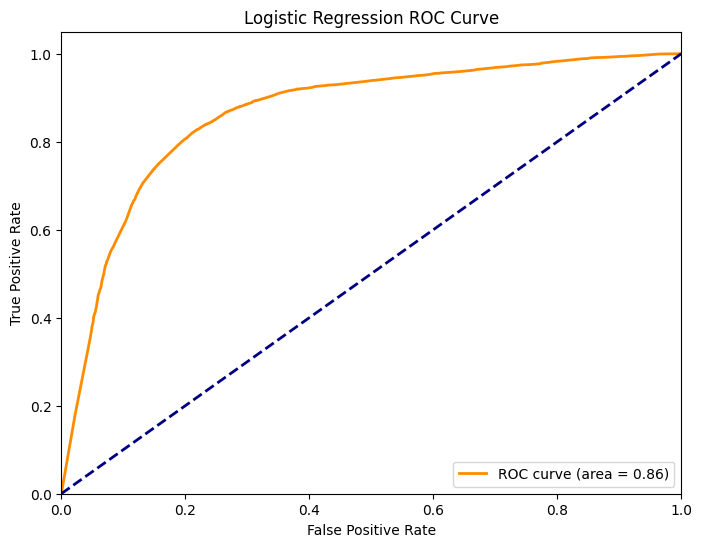

In [ ]:
gbt_true = gbt_preds.select('satisfaction_indexed').collect()
gbt_true = [row['satisfaction_indexed'] for row in gbt_true]

gbt_pred = gbt_preds.select('probability').rdd.map(lambda row: row[0][1]).collect()
gbt_pred = [float(prob) for prob in gbt_pred]

fpr, tpr, _ = roc_curve(gbt_true, gbt_pred)
gbt_roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {gbt_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression ROC Curve')
plt.legend(loc='lower right')
plt.show()